<a href="https://colab.research.google.com/github/pdoren/Machine-Learning-G105/blob/main/Prueba_Predicci%C3%B3n_del_precio_de_vuelos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba - Predicción del precio de vuelos

**Nombre**: Pablo Saavedra <br />
**Curso**: Machine Learning (G105)


---

### Importación de librerías

In [88]:
from __future__ import annotations

# --- Standard library ---
from typing import Any, Dict, Iterable, Optional

# --- Third-party ---
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer

import re
from datetime import datetime
from collections import Counter

from sklearn.preprocessing import LabelEncoder

from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor

from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# --- Pandas display options ---
pd.options.display.float_format = "{:,.2f}".format


In [89]:
!pip install xgboost

In [90]:
from xgboost import XGBRegressor

### Funciones útiles

In [4]:
def plot_hist(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _bins='auto'):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  for i, col in enumerate(_num_cols):
      sns.histplot(data=_df[col], kde=False, stat='density', ax=axes[i], bins=_bins)
      sns.kdeplot(data=_df[col], color='tomato', lw=3, ax=axes[i])
      axes[i].set_title(f"Distribución de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()

def plot_outliers(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))

  if isinstance(axes, np.ndarray):
      axes = axes.ravel()
  else:
      axes = np.array([axes])

  for i, col in enumerate(_num_cols):
      sns.boxplot(x=_df[col], flierprops = {'markerfacecolor':'tomato', 'marker':'D'}, ax=axes[i])
      axes[i].set_title(f"Outliers en {col}")
      axes[i].set_xlabel(col)

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def clean_outliers(_df: pd.DataFrame, _cols: list, _k: float=1.5):
  df_ret = _df.copy()
  for col in _cols:
    while True:
      q1, q3 = df_ret[col].quantile([.25, .75])
      iqr = q3 - q1
      low, high = q1 - _k * iqr, q3 + _k * iqr
      mask_out = (df_ret[col] < low) | (df_ret[col] > high)
      if mask_out.any():
        df_ret = df_ret[~mask_out]
      else:
        break
  return df_ret

def clean_outliers_percentiles(
    _df: pd.DataFrame,
    _cols: list,
    p_low: float = 1,     # percentil inferior
    p_high: float = 99    # percentil superior
):

    df_ret = _df.copy()

    for col in _cols:
        # Calcular umbrales por percentiles
        low = df_ret[col].quantile(p_low / 100)
        high = df_ret[col].quantile(p_high / 100)

        # Crear máscara de puntos válidos
        mask = (df_ret[col] >= low) & (df_ret[col] <= high)

        # Filtrar el DataFrame
        df_ret = df_ret[mask]

    return df_ret

def plot_count(_df: pd.DataFrame, _num_cols: list, _n_cols: int = 3, _X:str=None):
  total = len(_num_cols)
  n_rows = int(np.ceil(total / _n_cols))

  fig, axes = plt.subplots(n_rows, _n_cols, figsize=(5*_n_cols, 4*n_rows))
  axes = axes.flatten()  # Para iterar fácil

  if _X is not None:
    for i, col in enumerate(_num_cols):
        sns.countplot(x=_X, data=_df, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")
  else:
    for i, col in enumerate(_num_cols):
        sns.countplot(y=col, data=_df, order=_df[col].value_counts().index, ax=axes[i], hue=str(col))
        axes[i].set_title(f"Frecuencia de {col}")

  # Eliminar ejes vacíos si sobran
  for j in range(i+1, len(axes)):
      fig.delaxes(axes[j])

  plt.tight_layout()
  plt.show()


def eval_model(
  model,
  X_train, y_train,
  X_test,  y_test,
  class_names: Optional[Iterable[str]] = None,
  *,
  normalize_cm: str | None = "true",   # "true" | "pred" | "all" | None
  average: str = "weighted",           # "macro" | "weighted" | "micro"
  plot: bool = True,
  title_prefix: str = "",
  binary_threshold: Optional[float] = None,  # si None y hay proba, usa 0.5
  zero_division: int = 0,
  label_map: Optional[Dict[Any, int]] = None # parche: {'No':0,'Yes':1}, etc.
) -> Dict[str, Any]:
  """
  Evalúa un clasificador en train/test con métricas y (opcional) gráficos.
  Incluye parche para alinear tipos de etiqueta (p. ej., y_true en str y y_pred en int).
  Retorna un diccionario con métricas.

  Parámetros clave:
  - class_names: etiquetas para los ejes de las matrices de confusión.
  - label_map: mapeo explícito de etiquetas reales -> enteros del modelo.
  - binary_threshold: umbral de decisión si el modelo expone predict_proba/decision_function.
  """
  # ---------------------------
  # 0) Parche de etiquetas
  # ---------------------------
  y_train = np.asarray(y_train)
  y_test  = np.asarray(y_test)

  # ¿El modelo genera probabilidades / scores?
  has_proba    = hasattr(model, "predict_proba")
  has_decision = hasattr(model, "decision_function")

  # Predicciones "crudas"
  y_pred_train = model.predict(X_train)
  y_pred_test  = model.predict(X_test)

  # Detecta tipo de problema (binario/multiclase)
  target_kind = type_of_target(y_test)
  is_binary = target_kind == "binary"

  # Si viene un mapeo explícito, aplícalo a y_* reales
  if label_map is not None:
      y_train = np.vectorize(label_map.get)(y_train)
      y_test  = np.vectorize(label_map.get)(y_test)

  # Si aún hay choque de tipos (str vs int), intenta auto-mapeo seguro para binario
  def _needs_alignment(y_true, y_pred):
      return (np.asarray(y_true).dtype.kind in "OUS") and (np.asarray(y_pred).dtype.kind in "iu")

  if _needs_alignment(y_test, y_pred_test):
      if not is_binary:
          raise TypeError(
              "Las etiquetas verdaderas son strings y las predicciones enteros, y el problema no es binario. "
              "Pasa 'label_map' o entrena el modelo con etiquetas codificadas (LabelEncoder)."
          )
      # Caso binario: preferimos usar class_names si fue entregado con orden [neg, pos]
      if class_names is not None and len(list(class_names)) == 2:
          auto_map = {class_names[0]: 0, class_names[1]: 1}
          y_train = np.vectorize(auto_map.get)(y_train)
          y_test  = np.vectorize(auto_map.get)(y_test)
      else:
          # Intento de usar el orden natural de las clases observadas (no 100% seguro)
          uniq = list(np.unique(y_train))
          if len(uniq) == 2 and set(np.unique(y_pred_test)) <= {0, 1}:
              auto_map = {uniq[0]: 0, uniq[1]: 1}
              y_train = np.vectorize(auto_map.get)(y_train)
              y_test  = np.vectorize(auto_map.get)(y_test)
          else:
              raise TypeError(
                  "No se pudo alinear automáticamente y_true (strings) con y_pred (0/1). "
                  "Proporciona class_names=['No','Sí'] o label_map={'No':0,'Sí':1}."
              )

  # ---------------------------
  # 1) Umbral binario (si aplica)
  # ---------------------------
  proba_train = proba_test = None
  pos_scores_train = pos_scores_test = None

  if is_binary and (has_proba or has_decision):
      if has_proba:
          proba_train = model.predict_proba(X_train)
          proba_test  = model.predict_proba(X_test)
          pos_scores_train = proba_train[:, 1]
          pos_scores_test  = proba_test[:, 1]
      else:
          # decision_function
          pos_scores_train = model.decision_function(X_train)
          pos_scores_test  = model.decision_function(X_test)

      thr = 0.5 if binary_threshold is None else float(binary_threshold)
      y_pred_train = (pos_scores_train >= thr).astype(int)
      y_pred_test  = (pos_scores_test  >= thr).astype(int)

  # ---------------------------
  # 2) Métricas numéricas
  # ---------------------------
  metrics: Dict[str, Any] = {}

  def block_metrics(y_true, y_pred, split: str) -> Dict[str, float]:
      acc  = accuracy_score(y_true, y_pred)
      bacc = balanced_accuracy_score(y_true, y_pred)
      p, r, f1, _ = precision_recall_fscore_support(
          y_true, y_pred, average=average, zero_division=zero_division
      )
      mcc = matthews_corrcoef(y_true, y_pred)
      return {
          f"{split}_accuracy": acc,
          f"{split}_balanced_accuracy": bacc,
          f"{split}_precision_{average}": p,
          f"{split}_recall_{average}": r,
          f"{split}_f1_{average}": f1,
          f"{split}_mcc": mcc
      }

  metrics.update(block_metrics(y_train, y_pred_train, "train"))
  metrics.update(block_metrics(y_test,  y_pred_test,  "test"))

  # AUCs si tenemos scores
  if is_binary and (pos_scores_test is not None):
      try:
          metrics["train_roc_auc"] = roc_auc_score(y_train, pos_scores_train)
          metrics["test_roc_auc"]  = roc_auc_score(y_test,  pos_scores_test)
          metrics["train_pr_auc"]  = average_precision_score(y_train, pos_scores_train)
          metrics["test_pr_auc"]   = average_precision_score(y_test,  pos_scores_test)
      except Exception:
          pass

  # ---------------------------
  # 3) Reportes por clase (texto)
  # ---------------------------
  prefix = (title_prefix + " ") if title_prefix else ""
  print(prefix + "Reporte de clasificación (train):")
  print(classification_report(y_train, y_pred_train, digits=3, zero_division=zero_division))
  print(prefix + "Reporte de clasificación (test):")
  print(classification_report(y_test,  y_pred_test,  digits=3, zero_division=zero_division))

  # ---------------------------
  # 4) Gráficos
  # ---------------------------
  if plot:
      # Matrices de confusión
      fig, axes = plt.subplots(2, 2, figsize=(10, 8)) if is_binary and (pos_scores_test is not None) else plt.subplots(1, 2, figsize=(10, 4))
      axes = axes.flatten()

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_train, y_pred=y_pred_train,
          display_labels=class_names, normalize=normalize_cm, ax=axes[0]
      )
      axes[0].set_title(f"{title_prefix} Confusión (train)")

      ConfusionMatrixDisplay.from_predictions(
          y_true=y_test, y_pred=y_pred_test,
          display_labels=class_names, normalize=normalize_cm, ax=axes[1]
      )
      axes[1].set_title(f"{title_prefix} Confusión (test)")

      # Curvas ROC y PR (binario con scores)
      if is_binary and (pos_scores_test is not None):
          RocCurveDisplay.from_predictions(y_test, pos_scores_test, ax=axes[2])
          axes[2].set_title(f"{title_prefix} ROC (test)")

          PrecisionRecallDisplay.from_predictions(y_test, pos_scores_test, ax=axes[3])
          axes[3].set_title(f"{title_prefix} Precision-Recall (test)")

      plt.tight_layout(); plt.show()

  return metrics


def plot_corr(
    df,
    method="pearson",
    figsize=(12, 10),
    annot=False,
    cmap="coolwarm",
    vmin=-1,
    vmax=1
):
    """
    Muestra un heatmap de la matriz de correlación de un DataFrame.

    Parámetros
    ----------
    df : pandas.DataFrame
        DataFrame de entrada
    method : str
        Método de correlación: 'pearson', 'spearman', 'kendall'
    figsize : tuple
        Tamaño de la figura
    annot : bool
        Mostrar valores numéricos en el heatmap
    cmap : str
        Colormap
    vmin, vmax : float
        Límites de la escala de correlación
    """

    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include="number")

    if df_num.shape[1] < 2:
        raise ValueError("Se requieren al menos dos columnas numéricas.")

    # Calcular correlación
    corr = df_num.corr(method=method)

    # Plot
    plt.figure(figsize=figsize)
    sns.heatmap(
        corr,
        annot=annot,
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        square=True,
        linewidths=0.5,
        cbar_kws={"shrink": 0.8}
    )

    plt.title(f"Matriz de correlación ({method})", fontsize=14)
    plt.tight_layout()
    plt.show()

## 1. Descripción del Problema

Describe con detenimiento el problema de negocio que se desea resolver, y cómo se va a hacer esto. Indica la metodología, tareas a realizar, variable objetivo a predecir, etc.

---

> **Problema**: En una agencia de viajes en línea se quiere ofrecer a los clientes una herramienta que les permita **obtener estimaciones precisas del precio de los boletos de avión** para su próximo viaje. Sin embargo, el precio de un boleto de avión puede variar significativamente según múltiples factores, como la aerolínea, el destino, la temporada, la clase de servicio y la anticipación de la reserva.
>
> **Objetivo**: Generar una herramienta de estimación de precio de boleto para tener un impacto significativo en la industria de viajes y mejorar la experiencia de los viajeros.
>
> **Objetivo específico**: Con Machine Learning desarrollar un modelo predictivo capaz de estimar el precio de un boleto de avión basándonos en diversas características del vuelo. Este es un **problema de regresión** en donde la **variable objetivo es el precio del boleto**.
>
> **Metodología**: Para generar el modelo predictivo se seguiran los siguientes pasos y tareas:
>
> 1. Cargar y limpiar los datos
> 2. Explorar y transformar los datos
> 3. Seleccionar características relevantes
> 4. Seleccionar el modelo de regresión dada las características del problema
> 5. Entrenar el modelo buscando los mejores parámetros
> 6. Afinar modelos predictivos (Crossvalidation)
> 7. Evaluar el rendimiento del modelo


## 2. Carga de dataset

Carga los dataset entregados y genera un reporte de calidad de los mismos. Indica qué estrategias se van a utilizar para aquellos puntos encontrados (Indicar nulos, outliers, valores perdidos, que se hará con esto, etc.)

---

### Carga de datos

In [5]:
# Carga de datos business
df_business = pd.read_excel('/content/drive/MyDrive/business.xlsx')
df_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93487 entries, 0 to 93486
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        93487 non-null  datetime64[ns]
 1   airline     93487 non-null  object        
 2   ch_code     93487 non-null  object        
 3   num_code    93487 non-null  int64         
 4   dep_time    93487 non-null  object        
 5   from        93487 non-null  object        
 6   time_taken  93487 non-null  object        
 7   stop        93487 non-null  object        
 8   arr_time    93487 non-null  object        
 9   to          93487 non-null  object        
 10  price       93487 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(9)
memory usage: 7.8+ MB


In [6]:
# Carga de datos economy
df_economy = pd.read_excel('/content/drive/MyDrive/economy.xlsx')
df_economy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 206774 entries, 0 to 206773
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        206774 non-null  datetime64[ns]
 1   airline     206774 non-null  object        
 2   ch_code     206774 non-null  object        
 3   num_code    206774 non-null  int64         
 4   dep_time    206774 non-null  object        
 5   from        206774 non-null  object        
 6   time_taken  206774 non-null  object        
 7   stop        206774 non-null  object        
 8   arr_time    206774 non-null  object        
 9   to          206774 non-null  object        
 10  price       206774 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(8)
memory usage: 17.4+ MB


> Para poder trabajar con solo un data frame se concatena los data set de ambas clases (business y economy)

In [7]:
# Concatenar ambos dataframes
df_business['class'] = 'business'
df_economy['class'] = 'economy'
df = pd.concat([df_business, df_economy], ignore_index=True)

In [8]:
df.head(10)

,date,airline,ch_code,num_code,dep_time,from,time_taken,stop,arr_time,to,price,class
0,2022-02-11,Air India,AI,868,18:00:00,Delhi,02h 00m,non-stop,20:00:00,Mumbai,25612,business
1,2022-02-11,Air India,AI,624,19:00:00,Delhi,02h 15m,non-stop,21:15:00,Mumbai,25612,business
2,2022-02-11,Air India,AI,531,20:00:00,Delhi,24h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,20:45:00,Mumbai,42220,business
3,2022-02-11,Air India,AI,839,21:25:00,Delhi,26h 30m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55:00,Mumbai,44450,business
4,2022-02-11,Air India,AI,544,17:15:00,Delhi,06h 40m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,23:55:00,Mumbai,46690,business
5,2022-02-11,Vistara,UK,985,19:50:00,Delhi,02h 10m,non-stop,22:00:00,Mumbai,50264,business
6,2022-02-11,Air India,AI,479,21:15:00,Delhi,17h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,15:00:00,Mumbai,50669,business
7,2022-02-11,Air India,AI,473,18:40:00,Delhi,22h 45m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,17:25:00,Mumbai,51059,business
8,2022-02-11,Vistara,UK,871,20:35:00,Delhi,17h 55m,1-stop\n\t\t\t\t\t\t\t\t\t\t\t\t\n\t\t\t\t\t\t...,14:30:00,Mumbai,51731,business
9,2022-02-11,Vistara,UK,977,19:00:00,Delhi,02h 15m,non-stop,21:15:00,Mumbai,53288,business


In [9]:
# Cantidad de nulos
print("Cantidad de nulos", df.isnull().sum())

Cantidad de nulos date          0
airline       0
ch_code       0
num_code      0
dep_time      0
from          0
time_taken    0
stop          0
arr_time      0
to            0
price         0
class         0
dtype: int64


In [10]:
# Cantidad de registros duplicados
print("Cantidad de duplicados: ", df.duplicated().sum())

Cantidad de duplicados:  2


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300261 entries, 0 to 300260
Data columns (total 12 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        300261 non-null  datetime64[ns]
 1   airline     300261 non-null  object        
 2   ch_code     300261 non-null  object        
 3   num_code    300261 non-null  int64         
 4   dep_time    300261 non-null  object        
 5   from        300261 non-null  object        
 6   time_taken  300261 non-null  object        
 7   stop        300261 non-null  object        
 8   arr_time    300261 non-null  object        
 9   to          300261 non-null  object        
 10  price       300261 non-null  object        
 11  class       300261 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(10)
memory usage: 27.5+ MB


> **Reporte de los datos**:
> - Se tiene un total de 206.774 registros (ambas clases en total).
> - No existen valores nulos
> - 2 registros duplicados
> - Existen 3 columnas que hacen referencia a fechas y tiempo: date, dep_time, time_taken y arr_time. En un análisis rápido se puede ver que arr_time es redundante debido a que solo es la suma entre dep_time y time_taken.
> - Las columnas from y to indican una ciudad.
> - La columa stop indica la cantidad de paradas en un string. Esto puede ser convertido a un número entero. Esta columna también muestra que contiene carácteres extras que deben ser procesados antes de convertir a número.
> - Las columnas num_code y ch_code son columnas que identifican el vuelo. Mientras que airline la aerolina del mismo.
> - Probablemente ch_code y airline tengan una fuerte correlación porque identifican a la aerolinea.

> **Tratamiento de los datos**:
> - **Exploración de los datos**: para determinar si hay columnas que se pueden eliminar o reducir para facilitar el tratamiento en el modelo. Además de ver si es posible generar nuevas columnas que puedan aportar información adicional al modelo
> - **Nulos**: Como no hay datos nulos no se realiza nada
> - **Duplicados**: Eliminar duplicados
> - **Outliers**: Se utilizará el método IQR para eliminar los outliers


## 3. Análisis exploratorio

Genera un análisis exploratorio de los dataset entregados, un análisis univariado y bivariado. Prioriza los gráficos más importantes y entrega una conclusión a partir de estos.

---

In [12]:
# Eliminar duplicados
df = df.drop_duplicates()

In [13]:
# Copiar dataframe para realizar la limpieza de datos
df_limpio = df.copy()

> Revisar columnas **airline** y **ch_code**

In [14]:
# Diferentes aerolineas
print("Diferentes aerolineas: ", df_limpio['airline'].unique())

Diferentes aerolineas:  ['Air India' 'Vistara' 'SpiceJet' 'AirAsia' 'GO FIRST' 'Indigo' 'Trujet'
 'StarAir']


In [15]:
# Diferentes ch_code
print("Diferentes CH Code: ", df_limpio['ch_code'].unique())

Diferentes CH Code:  ['AI' 'UK' 'SG' 'I5' 'G8' '6E' '2T' 'S5']


> Para poder ver si una aerolínea está asociada a un solo código ch_code se utiliza la tabla de contingencia en donde se obtiene que el código corresponde a una aerolínea dedido a que airline tiene un solo valor de código diferente de cero asociado

In [16]:
pd.crosstab(df["airline"], df["ch_code"])

ch_code,2T,6E,AI,G8,I5,S5,SG,UK
airline,,,,,,,,
Air India,0,0,80892,0,0,0,0,0
AirAsia,0,0,0,0,16098,0,0,0
GO FIRST,0,0,0,23177,0,0,0,0
Indigo,0,43120,0,0,0,0,0,0
SpiceJet,0,0,0,0,0,0,9011,0
StarAir,0,0,0,0,0,61,0,0
Trujet,41,0,0,0,0,0,0,0
Vistara,0,0,0,0,0,0,0,127859


> Tabla de correspondencias
| airline    | ch_code |
|------------|---------|
| Air India  | AI      |
| AirAsia   | I5      |
| GO FIRST  | G8      |
| Indigo    | 6E      |
| SpiceJet  | SG      |
| StarAir   | S5      |
| Trujet    | 2T      |
| Vistara   | UK      |


In [17]:
# Eliminar airline
df_limpio = df_limpio.drop(columns=["airline"])

> Columna **Num_code**

In [18]:
# Cantidad de diferentes num_code
print("Cantidad de diferentes Num Code: ", df['num_code'].nunique())

Cantidad de diferentes Num Code:  1255


Columna **dep_time**

In [19]:
# Convertir tiempo de columa dep_time a minutos
df_limpio["dep_time"] = (
    df_limpio["dep_time"].apply(lambda t: t.hour * 60 + t.minute)
)

Columna **time_taken**

In [20]:
# Convertir a minutos la columan time_taken
s = df_limpio["time_taken"].astype(str).str.lower().str.strip()

# Extraer horas (enteras o decimales) y minutos (enteros)
hm = s.str.extract(r'(?:(\d+(?:\.\d+)?)\s*h)?\s*(?:(\d+)\s*m)?')

hours = pd.to_numeric(hm[0], errors="coerce")
mins  = pd.to_numeric(hm[1], errors="coerce")

# Convertir todo a minutos
df_limpio["time_taken"] = (
    hours.fillna(0) * 60 +
    mins.fillna(0)
)

> Columna **arr_time**

In [21]:
# Eliminar columna arr_time
df_limpio = df_limpio.drop(columns=["arr_time"])

> Columna **stop**

In [22]:
# Eliminar espacios en stop
df_limpio["stop"] = df_limpio["stop"].str.strip()

In [23]:
df_limpio["stop"].unique()

array(['non-stop', '1-stop', '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IDR',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXU',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Chennai',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Lucknow',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia STV',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Hyderabad',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GAY', '2+-stop',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Guwahati',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia GAU',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia VTZ',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia NDC',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia IXE',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Raipur',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia PAT',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia RPR',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Patna',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia Kolkata',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\tVia HYD',
       '1-stop\n\t\t\t\t\t\t\t\t\t\t\t\

In [24]:
# Separar en columna stop la Via y dejar en stop el número de paradas y en una nueva columa llamada via el nombre de la Via, si no tiene via colocar none
s = df_limpio["stop"].astype(str)

# ---------
# 1) Columna stop
# ---------
df_limpio["stop"] = (
    s.str.extract(r'(\d+)\s*(?:\+)?-stop')[0]
     .fillna(0)
     .astype(int)
)

# non-stop -> 0
df_limpio.loc[s.str.contains("non-stop", case=False), "stop"] = 0


# ---------
# 2) Columna via
# ---------
df_limpio["via"] = (
    s.str.extract(r'Via\s+([A-Za-z]+)')[0]
     .fillna("none")
)

> Columna **price**

In [25]:
# Convertir a número la columna price
df_limpio["price"] = pd.to_numeric(df_limpio["price"], errors="coerce")
df_limpio = df_limpio.dropna()

In [26]:
df_limpio.head(10)

,date,ch_code,num_code,dep_time,from,time_taken,stop,to,price,class,via
0,2022-02-11,AI,868,1080,Delhi,120.00,0,Mumbai,"25,612.00",business,none
1,2022-02-11,AI,624,1140,Delhi,135.00,0,Mumbai,"25,612.00",business,none
2,2022-02-11,AI,531,1200,Delhi,"1,485.00",1,Mumbai,"42,220.00",business,none
3,2022-02-11,AI,839,1285,Delhi,"1,590.00",1,Mumbai,"44,450.00",business,none
4,2022-02-11,AI,544,1035,Delhi,400.00,1,Mumbai,"46,690.00",business,none
5,2022-02-11,UK,985,1190,Delhi,130.00,0,Mumbai,"50,264.00",business,none
6,2022-02-11,AI,479,1275,Delhi,"1,065.00",1,Mumbai,"50,669.00",business,none
7,2022-02-11,AI,473,1120,Delhi,"1,365.00",1,Mumbai,"51,059.00",business,none
8,2022-02-11,UK,871,1235,Delhi,"1,075.00",1,Mumbai,"51,731.00",business,none
9,2022-02-11,UK,977,1140,Delhi,135.00,0,Mumbai,"53,288.00",business,none


> Revisión de estadísticas

In [27]:
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 300151 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        300151 non-null  datetime64[ns]
 1   ch_code     300151 non-null  object        
 2   num_code    300151 non-null  int64         
 3   dep_time    300151 non-null  int64         
 4   from        300151 non-null  object        
 5   time_taken  300151 non-null  float64       
 6   stop        300151 non-null  int64         
 7   to          300151 non-null  object        
 8   price       300151 non-null  float64       
 9   class       300151 non-null  object        
 10  via         300151 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 27.5+ MB


In [28]:
# Estadísticas de variables cuantitativas
variables_cuantitativas = ["date", "dep_time", "time_taken", "price"]
df_limpio[variables_cuantitativas].describe()

,date,dep_time,time_taken,price
count,300151,"300,151.00","300,151.00","300,151.00"
mean,2022-03-08 00:15:41.286219264,806.03,733.01,"20,853.40"
min,2022-02-11 00:00:00,10.00,50.00,"1,105.00"
25%,2022-02-25 00:00:00,510.00,405.00,"4,783.00"
50%,2022-03-08 00:00:00,775.00,675.00,"7,425.00"
75%,2022-03-20 00:00:00,"1,110.00",970.00,"42,521.00"
max,2022-03-31 00:00:00,"1,435.00","2,990.00","99,680.00"
std,NaN,323.36,431.60,"22,643.23"


In [29]:
# Estadística de variables categoricas
variables_cualitativas = ["num_code", "ch_code", "from", "stop", "to", "via", "class"]
df_limpio.describe(include="object")

,ch_code,from,to,class,via
count,300151,300151,300151,300151,300151
unique,8,6,6,2,38
top,UK,Delhi,Mumbai,economy,none
freq,127751,61318,59086,206772,292825


> Distribución de los datos

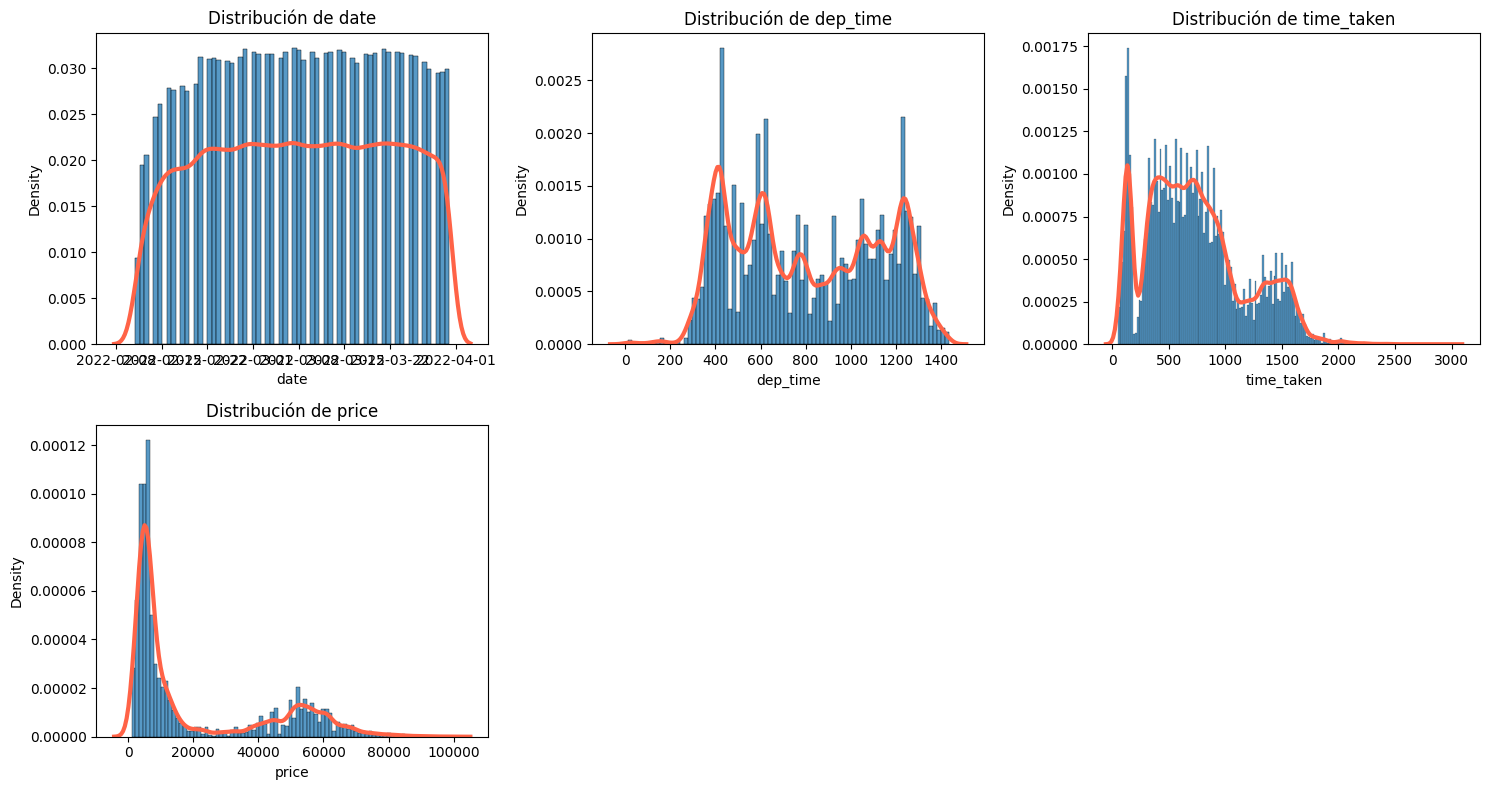

In [30]:
# Variables cuantitativas
plot_hist(df_limpio, variables_cuantitativas)

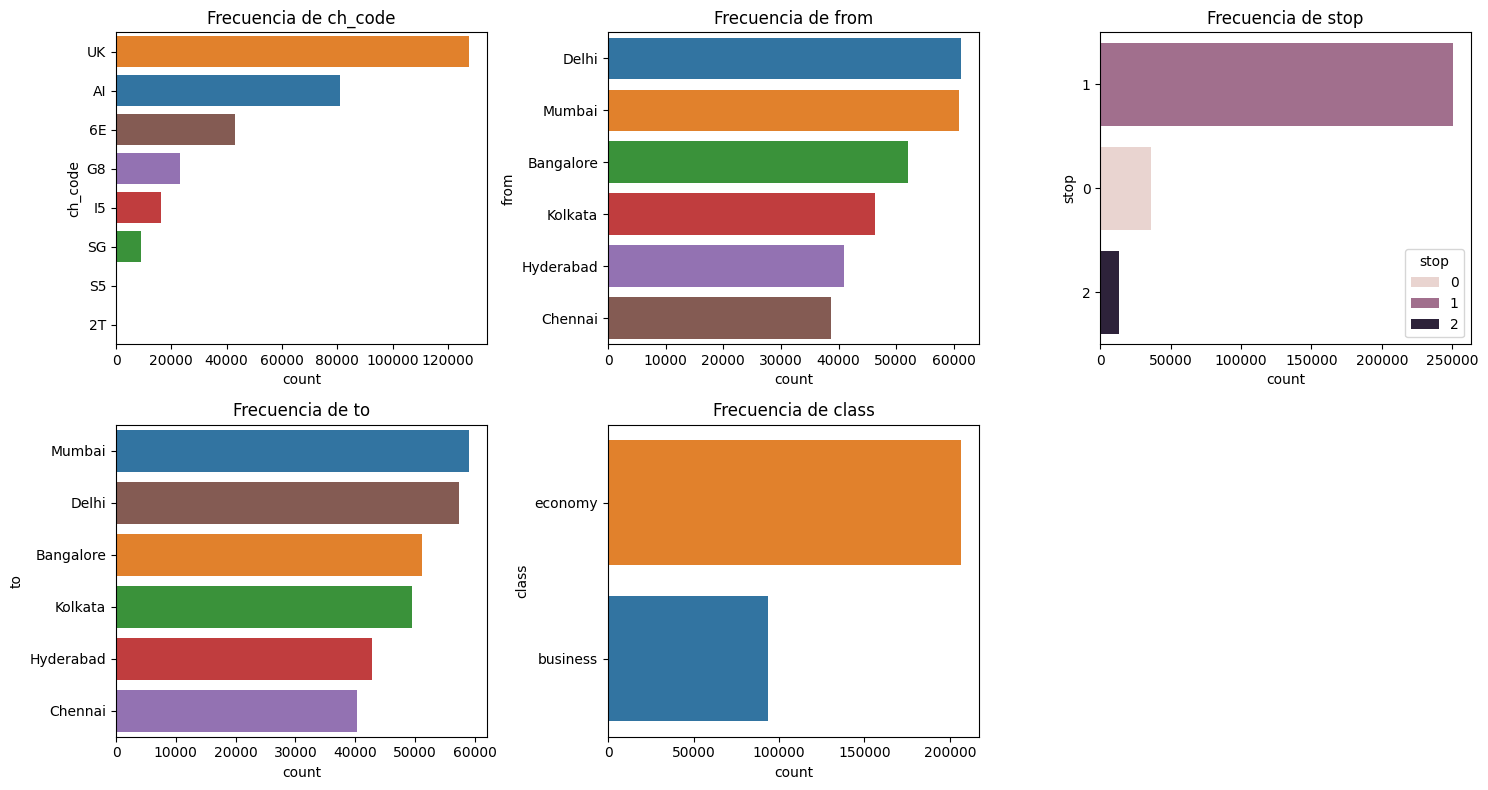

In [31]:
# Variables cualitativas
list_temp = variables_cualitativas.copy()
list_temp.remove('via')  # se descarta via por la cantidad de labels
list_temp.remove('num_code')  # se descarta num_code por la cantidad de labels
plot_count(df_limpio, list_temp)

> La distribución de los datos indican:
> - Variables Cuantitativas:
>    - Ninguno de los datos ditribuye de forma normal
>    - La columna date distribuye de forma uniforme
>    - La columna price aparentemente tiene 2 medias
> - Variables Cualitativas:
>    - Las frecuencias de los datos no están balanceadas
>    - Los datos de clase economy son más del doble que de business
>    - Casi todos los viajes tienen al menos una para (columna stop)
>    - Las frecuencias de ciudades origen destino se parecen mucho. Probablemente existen pares entre ellos que se repiten.
>    - En la columna ch_code que representa al las aerolíneas se observa que UK   

> Las 2 medias observadas en price se debe a los 2 conjuntos de datos de cada clase: business y economy. Esto se puede ver en los gráficos de abajo:

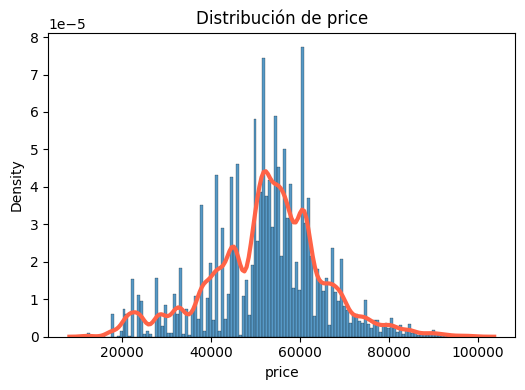

In [32]:
plot_hist(df_limpio[df_limpio['class']=='business'], ['price'])

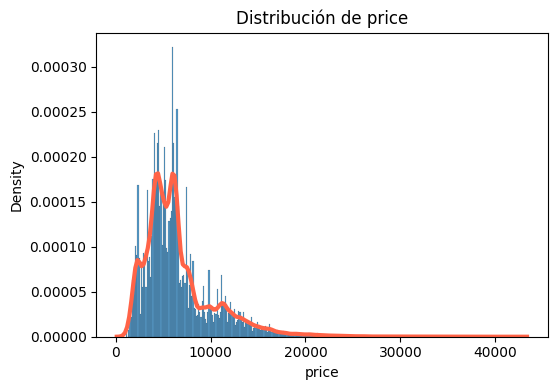

In [33]:
plot_hist(df_limpio[df_limpio['class']=='economy'], ['price'])

> **Outliers**: Para eliminar los outliers se utilizará el método IQR


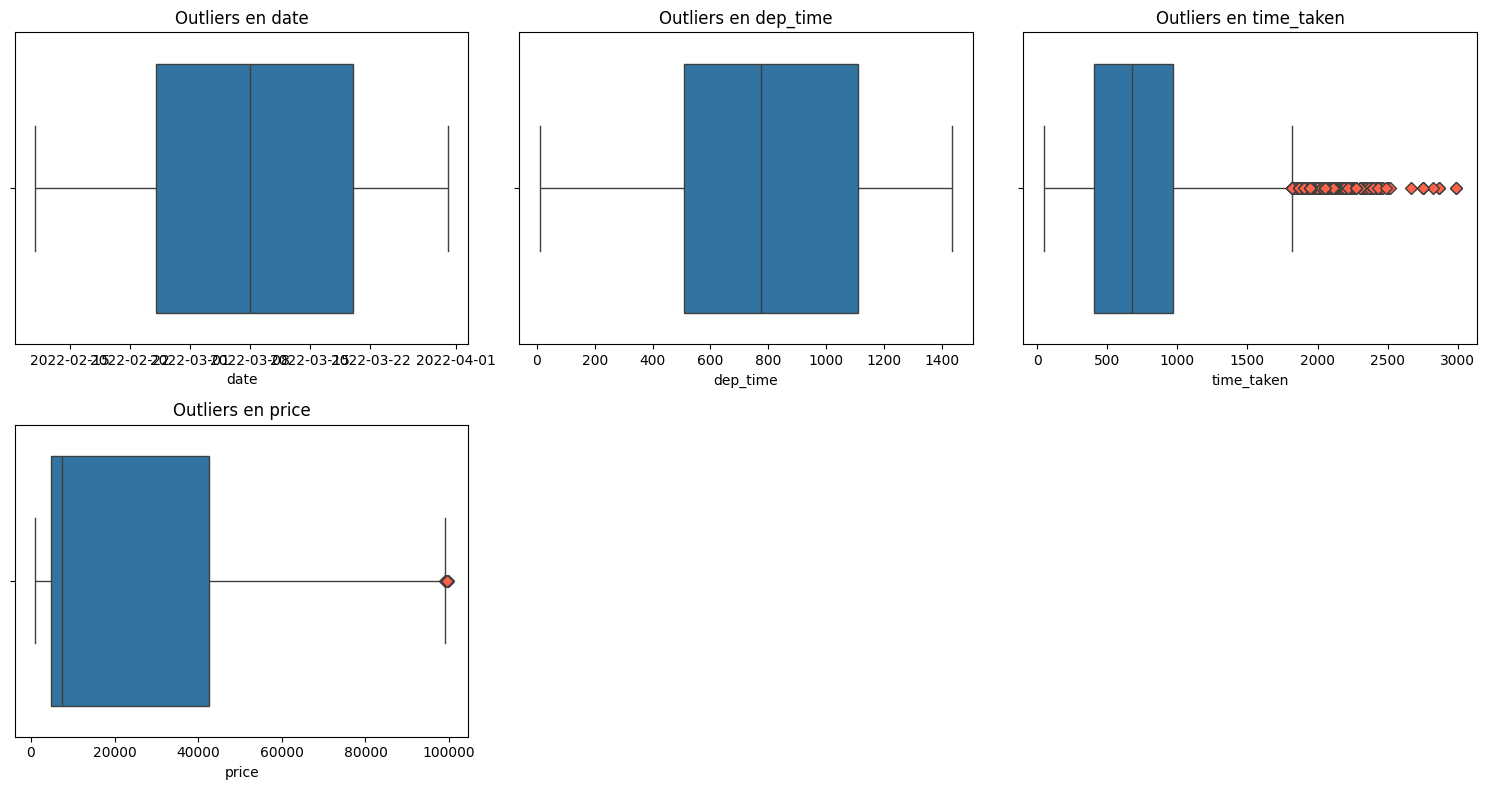

In [34]:
plot_outliers(df_limpio, variables_cuantitativas)

> Se observan pocos outliers y solo presentes en la variables price y time_taken

In [35]:
df_limpio1 = clean_outliers(df_limpio, variables_cuantitativas)  # método de limpieza usando IQR con K=3.0 (para no liminar tantos datos)

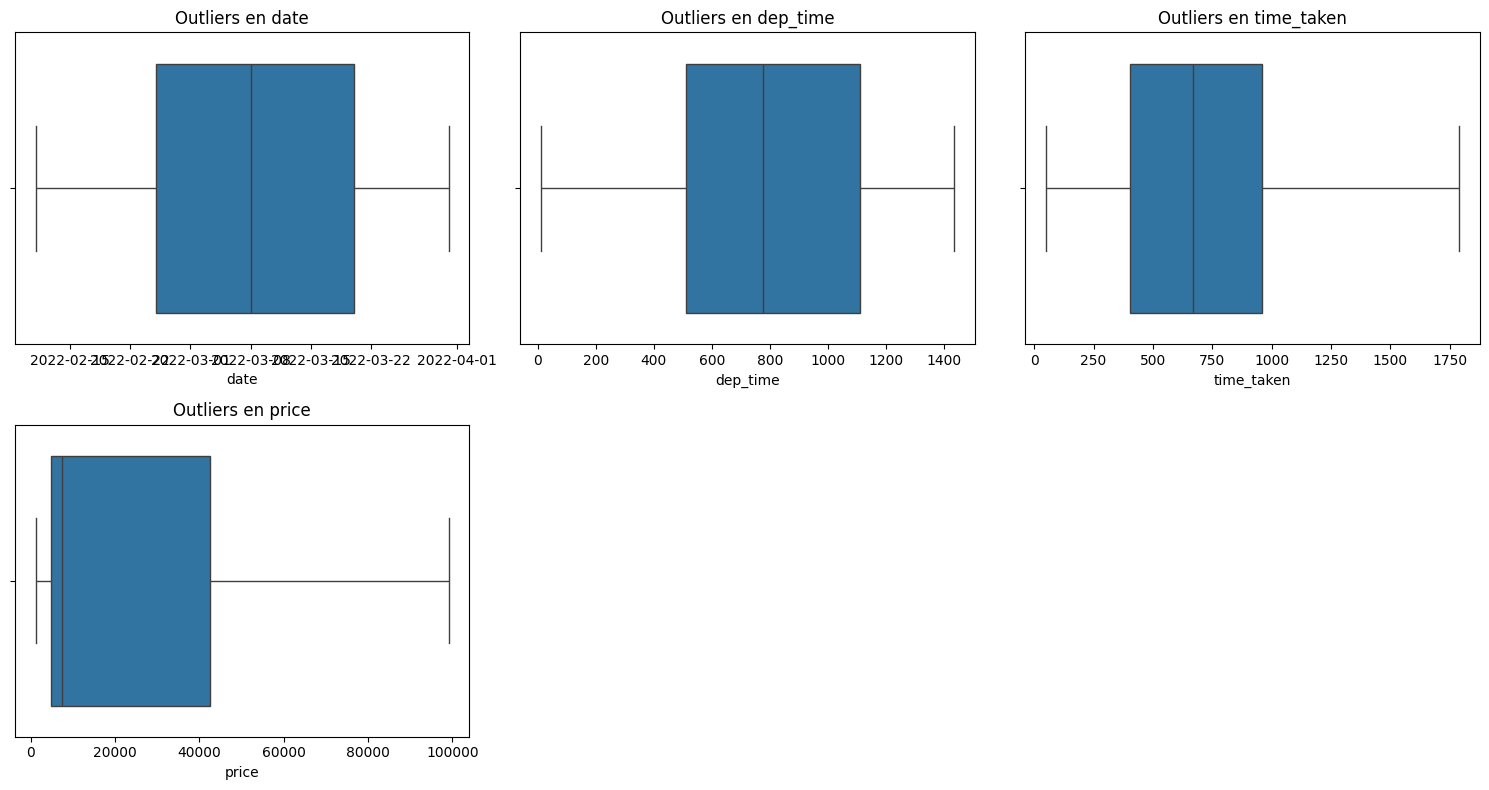

In [36]:
plot_outliers(df_limpio1, variables_cuantitativas)

In [37]:
print(f"Se eliminó el {100*(1 - (len(df_limpio1)/len(df_limpio))):.2f}% de registros")

Se eliminó el 0.78% de registros


In [38]:
df_limpio = df_limpio1
df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297801 entries, 0 to 300260
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   date        297801 non-null  datetime64[ns]
 1   ch_code     297801 non-null  object        
 2   num_code    297801 non-null  int64         
 3   dep_time    297801 non-null  int64         
 4   from        297801 non-null  object        
 5   time_taken  297801 non-null  float64       
 6   stop        297801 non-null  int64         
 7   to          297801 non-null  object        
 8   price       297801 non-null  float64       
 9   class       297801 non-null  object        
 10  via         297801 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(3), object(5)
memory usage: 27.3+ MB


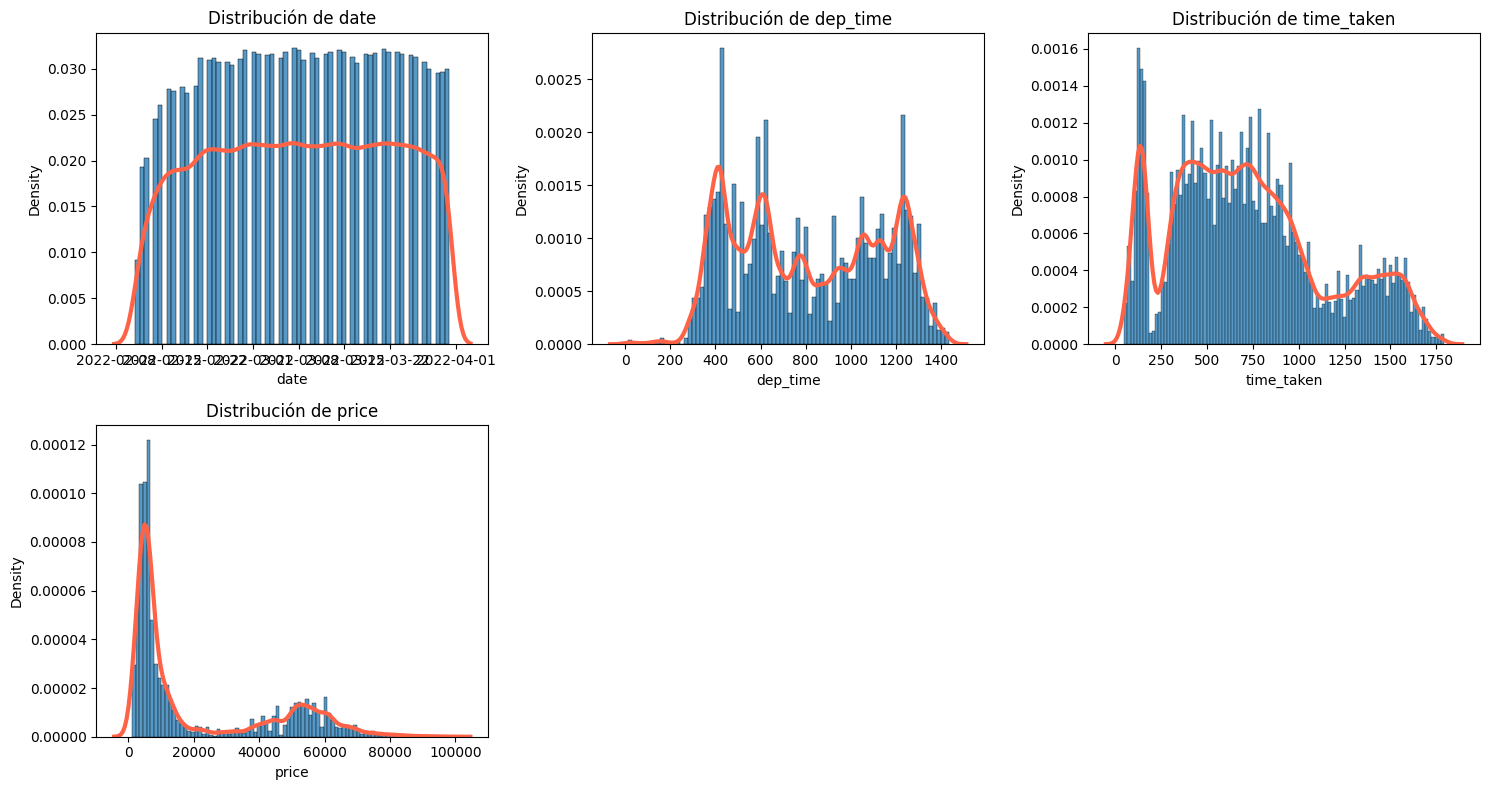

In [39]:
plot_hist(df_limpio, variables_cuantitativas)

> Al eliminar los outliers no se ve un cambio relevante en los gráficos de distribución de los datos

## 5. Análisis de Correlaciones

Realiza un análisis de correlaciones entre las diferentes variables existentes, identificando cuáles son las variables más importantes para la predicción de la variable objetivo. Utiliza las técnicas vistas en el curso.

---

> Se calcula la correlación Spearman debido a que las variables NO son normales ni lineales

In [40]:
# Para mostrar la correlación de todas las variables es necesario cambiar
# los labels a números en las variables categóricas
df_limpio1 = df_limpio.copy()
le = LabelEncoder()
df_limpio1["from"] = le.fit_transform(df_limpio1["from"])
df_limpio1["to"] = le.fit_transform(df_limpio1["to"])
df_limpio1["via"] = le.fit_transform(df_limpio1["via"])
df_limpio1["class"] = le.fit_transform(df_limpio1["class"])
df_limpio1['ch_code'] = le.fit_transform(df_limpio1['ch_code'])


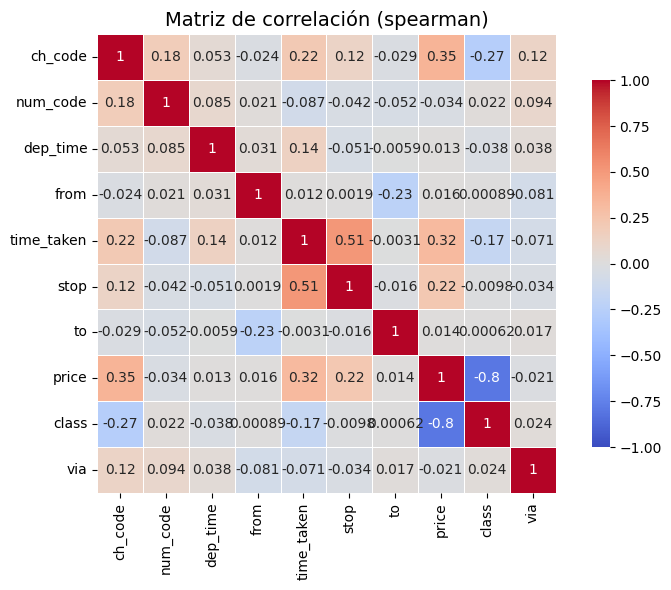

In [41]:
# Mostrar un gráfico con la matriz de correlación
plot_corr(df_limpio1, method="spearman",
    figsize=(8, 6), annot=True)

> **Correlación**:
> - La correlación más grande con el precio del boleto es la clase del vuelo (-0.8). El valor negativo se debe a la elección de representación númerica entre las clases (LabelEncoder)
> - Las otras correlaciones importantes respecto al precio son:
>    - ch_code o aerolínea (0.35)
>    - time_taken o tiempo de vuelo (0.32)
>    - stop o cantidad de paradas (0.22)
> - Existe una correlación entre el tiempo total del viaje con respecto al total de las paradas. Esto tiene sentido, más paradas intermedias, más tiempo de viaje

> Revisar correlación por clase de vuelo

> Correlación Clase Economy

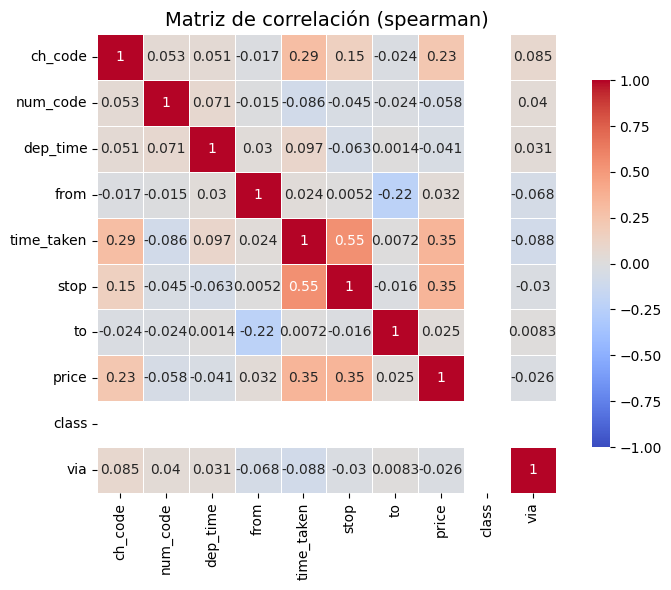

In [42]:
# Mostrar un gráfico con la matriz de correlación clase económica
plot_corr(df_limpio1[df_limpio1['class'] == 1], method="spearman",
    figsize=(8, 6), annot=True)

> Correlación Clase Business

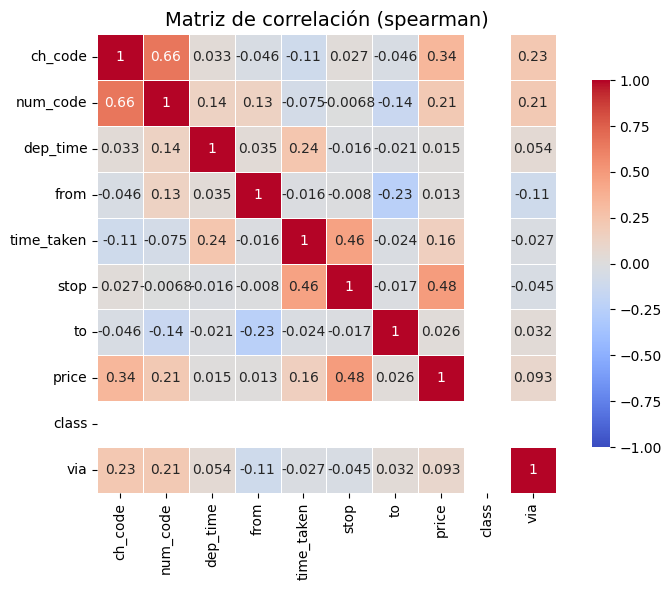

In [43]:
# Mostrar un gráfico con la matriz de correlación clase business
plot_corr(df_limpio1[df_limpio1['class'] == 0], method="spearman",
    figsize=(8, 6), annot=True)

> - Se observa una mayor correlación del precio con la aerolínea con clase business. Incluso con el número o código del vuelo.
> - La cantidad de paradas y el precio tienen mayor correlación en business
> - El tiempo de viaje tiene mayor correlación con el precio en clase economy
> - Existe una correlación importante entre ch_code y num_code en clase business

## 5. Transformación de los datos

Realiza las transformaciones necesarias para realizar el modelamiento posterior y crea las variables que estimes convenientes con ayuda del análisis previo y la expertise del negocio.

---

> Primero se convertira las fechas en un dato más importante para el problema:

In [44]:
# agregar nuevas columnas
df_limpio["day"] = df_limpio["date"].dt.day
df_limpio["month"] = df_limpio["date"].dt.month
df_limpio["dayofweek"] = df_limpio["date"].dt.dayofweek
df_limpio["is_weekend"] = df_limpio["dayofweek"].isin([5,6]).astype(int)
# Eliminar date
df_limpio = df_limpio.drop(columns=["date"])

> Momento en el día, dep_time es el tiempo en minutos del día y lo que ayuda más es saber en que momento en el día parte el viaje (Vuelos nocturnos vs peak hours). Se usa coseno y seno para representar el aumento de precio según el momento del día (periodo de 1440 minutos, es decir, un día completo)

In [45]:
df_limpio["dep_sin"] = np.sin(2 * np.pi * df_limpio["dep_time"] / 1440)
df_limpio["dep_cos"] = np.cos(2 * np.pi * df_limpio["dep_time"] / 1440)

> Ruta de viaje

In [46]:
df_limpio["route"] = df_limpio["from"] + "_" + df_limpio["to"]

> Todas las variables

In [54]:
# Covertir a números
le = LabelEncoder()
df_limpio["from"] = le.fit_transform(df_limpio["from"])
df_limpio["to"] = le.fit_transform(df_limpio["to"])
df_limpio["via"] = le.fit_transform(df_limpio["via"])
df_limpio["class"] = le.fit_transform(df_limpio["class"])
df_limpio['ch_code'] = le.fit_transform(df_limpio['ch_code'])
df_limpio['route'] = le.fit_transform(df_limpio['route'])

df_limpio.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297801 entries, 0 to 300260
Data columns (total 17 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   ch_code     297801 non-null  int64  
 1   num_code    297801 non-null  int64  
 2   dep_time    297801 non-null  int64  
 3   from        297801 non-null  int64  
 4   time_taken  297801 non-null  float64
 5   stop        297801 non-null  int64  
 6   to          297801 non-null  int64  
 7   price       297801 non-null  float64
 8   class       297801 non-null  int64  
 9   via         297801 non-null  int64  
 10  day         297801 non-null  int32  
 11  month       297801 non-null  int32  
 12  dayofweek   297801 non-null  int32  
 13  is_weekend  297801 non-null  int64  
 14  dep_sin     297801 non-null  float64
 15  dep_cos     297801 non-null  float64
 16  route       297801 non-null  int64  
dtypes: float64(4), int32(3), int64(10)
memory usage: 37.5 MB


> Seleccionar las variables más representativas

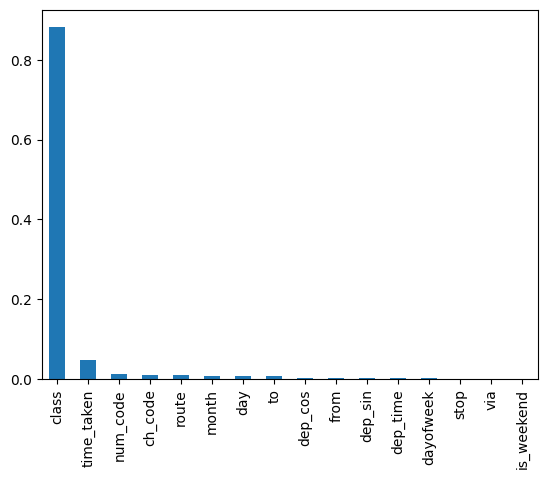

In [55]:
X = df_limpio.drop(columns=["price"])
y = df_limpio["price"]

model = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)
model.fit(X, y)

importances = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

importances.plot(kind='bar')
plt.show()

In [58]:
pd.options.display.float_format = "{:,.4f}".format
importances

,0
class,0.8814
time_taken,0.0484
num_code,0.0135
ch_code,0.0105
route,0.0105
month,0.0075
day,0.0070
to,0.0069
dep_cos,0.0032
from,0.0025


> Entonces se seleccionaran 8 variables:

In [ ]:
variables_sel = ['class', 'time_taken', 'num_code', 'ch_code', 'route', 'month', 'day', 'to']

## 6. Genera una función

Genera una función que resuma todo el procesamiento necesario para el dataset, que lea el dataset original y entregue un dataset ya tratado, con las columnas transformadas y creadas.

In [108]:
def clean_data(_df, _del_date=True):
  df = _df.copy()

  # Eliminar duplicados
  df = df.drop_duplicates()

  # Eliminar NaN
  df = df.dropna()

  # Copiar dataframe para realizar la limpieza de datos
  df_limpio = df.copy()

  # Eliminar airline
  df_limpio = df_limpio.drop(columns=["airline"])

  # Convertir tiempo de columa dep_time a minutos
  df_limpio["dep_time"] = (
      df_limpio["dep_time"].apply(lambda t: t.hour * 60 + t.minute)
  )

  # Convertir a minutos la columan time_taken
  s = df_limpio["time_taken"].astype(str).str.lower().str.strip()

  # Extraer horas (enteras o decimales) y minutos (enteros)
  hm = s.str.extract(r'(?:(\d+(?:\.\d+)?)\s*h)?\s*(?:(\d+)\s*m)?')

  hours = pd.to_numeric(hm[0], errors="coerce")
  mins  = pd.to_numeric(hm[1], errors="coerce")

  # Convertir todo a minutos
  df_limpio["time_taken"] = (
      hours.fillna(0) * 60 +
      mins.fillna(0)
  )

  # Eliminar columna arr_time
  df_limpio = df_limpio.drop(columns=["arr_time"])

  # Eliminar espacios en stop
  df_limpio["stop"] = df_limpio["stop"].str.strip()

  # Separar en columna stop la Via y dejar en stop el número de paradas y en una nueva columa llamada via el nombre de la Via, si no tiene via colocar none
  s = df_limpio["stop"].astype(str)

  # ---------
  # 1) Columna stop
  # ---------
  df_limpio["stop"] = (
      s.str.extract(r'(\d+)\s*(?:\+)?-stop')[0]
      .fillna(0)
      .astype(int)
  )

  # non-stop -> 0
  df_limpio.loc[s.str.contains("non-stop", case=False), "stop"] = 0


  # ---------
  # 2) Columna via
  # ---------
  df_limpio["via"] = (
      s.str.extract(r'Via\s+([A-Za-z]+)')[0]
      .fillna("none")
  )

  # Convertir a número la columna price
  df_limpio["price"] = pd.to_numeric(df_limpio["price"], errors="coerce")
  df_limpio = df_limpio.dropna()

  variables_cuantitativas = ["date", "dep_time", "time_taken", "price"]
  df_limpio = clean_outliers(df_limpio, variables_cuantitativas)

  # agregar nuevas columnas
  df_limpio["day"] = df_limpio["date"].dt.day
  df_limpio["month"] = df_limpio["date"].dt.month
  df_limpio["dayofweek"] = df_limpio["date"].dt.dayofweek
  df_limpio["is_weekend"] = df_limpio["dayofweek"].isin([5,6]).astype(int)
  # Eliminar date
  if _del_date:
    df_limpio = df_limpio.drop(columns=["date"])

  df_limpio["dep_sin"] = np.sin(2 * np.pi * df_limpio["dep_time"] / 1440)
  df_limpio["dep_cos"] = np.cos(2 * np.pi * df_limpio["dep_time"] / 1440)

  df_limpio["route"] = df_limpio["from"] + "_" + df_limpio["to"]

  le = LabelEncoder()
  df_limpio["from"] = le.fit_transform(df_limpio["from"])
  df_limpio["to"] = le.fit_transform(df_limpio["to"])
  df_limpio["via"] = le.fit_transform(df_limpio["via"])
  df_limpio["class"] = le.fit_transform(df_limpio["class"])
  df_limpio['ch_code'] = le.fit_transform(df_limpio['ch_code'])
  df_limpio['route'] = le.fit_transform(df_limpio['route'])

  var_sel = ['class', 'time_taken', 'num_code', 'ch_code', 'route', 'month', 'day', 'to', 'price'] if _del_date else ['class', 'time_taken', 'num_code', 'ch_code', 'route', 'month', 'day', 'to', 'price', 'date']
  return df_limpio[var_sel]


In [64]:
df_preprocesado = clean_data(df)

In [65]:
df_preprocesado.info()

<class 'pandas.core.frame.DataFrame'>
Index: 297801 entries, 0 to 300260
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   class       297801 non-null  int64  
 1   time_taken  297801 non-null  float64
 2   num_code    297801 non-null  int64  
 3   ch_code     297801 non-null  int64  
 4   route       297801 non-null  int64  
 5   month       297801 non-null  int32  
 6   day         297801 non-null  int32  
 7   to          297801 non-null  int64  
 8   price       297801 non-null  float64
dtypes: float64(2), int32(2), int64(5)
memory usage: 20.4 MB


In [66]:
df_preprocesado.head()

,class,time_taken,num_code,ch_code,route,month,day,to,price
0,0,120.0000,868,2,14,2,11,5,"25,612.0000"
1,0,135.0000,624,2,14,2,11,5,"25,612.0000"
2,0,"1,485.0000",531,2,14,2,11,5,"42,220.0000"
3,0,"1,590.0000",839,2,14,2,11,5,"44,450.0000"
4,0,400.0000,544,2,14,2,11,5,"46,690.0000"


## 7. Modelos y split dataset

Elige al menos 3 modelos candidatos para resolver el problema. A partir de esto, genera un conjunto de entrenamiento y prueba, para luego entrenar los diferentes modelos.

---

In [73]:
# Separar data set limpio en conjunto de entrenamiento y prueba
X = df_preprocesado.drop(columns=["price"])
y = df_preprocesado["price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

> Se utilizarán 4 modelos, 3 no lineales y 1 líneal, este último es para servir como línea base de comparación:


In [74]:
# Modelo Lineal Ridge
ridge = Ridge()

# Modelos no lineales

# RandomForest
rf = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

# HistGradientBoostingRegressor
hgb = HistGradientBoostingRegressor(random_state=42)

# GXBoost
xgb = XGBRegressor(
    objective="reg:absoluteerror",
    tree_method="hist", random_state=42, n_jobs=-1)


## 8. Seleccionar parámetros

Elige una grilla de hiperparametros y luego optimízalos, buscando la mejor combinación para cada grilla. Guardar los modelos entrenados.

---

In [76]:
scoring = "neg_mean_absolute_error"
cv = 5

> Modelo Ridge

In [78]:
param_grid_ridge = {
    "alpha": [0.1, 1, 10, 50, 100]
}

grid_ridge = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid_ridge,
    scoring=scoring,
    cv=cv,
    n_jobs=-1
)

grid_ridge.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 10, 50, 100]},
             scoring='neg_mean_absolute_error')

In [79]:
best_ridge = grid_ridge.best_estimator_
grid_ridge.best_params_, -grid_ridge.best_score_

({'alpha': 0.1}, np.float64(4474.463580108071))

> Modelo RandomForest

In [84]:
param_dist_rf = {
    "n_estimators": [80, 120, 200],
    "max_depth": [12, 16, 20, None],
    "min_samples_leaf": [5, 10, 20],
    "max_features": ["sqrt", 0.5, 0.7]
}

rand_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist_rf,
    n_iter=15,
    scoring=scoring,
    cv=cv,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rand_rf.fit(X_train, y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


/usr/local/lib/python3.12/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(n_estimators=300, n_jobs=-1,
                                                   random_state=42),
                   n_iter=15, n_jobs=-1,
                   param_distributions={'max_depth': [12, 16, 20, None],
                                        'max_features': ['sqrt', 0.5, 0.7],
                                        'min_samples_leaf': [5, 10, 20],
                                        'n_estimators': [80, 120, 200]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [85]:
best_rf = rand_rf.best_estimator_
rand_rf.best_params_, -rand_rf.best_score_

({'n_estimators': 200,
  'min_samples_leaf': 10,
  'max_features': 0.7,
  'max_depth': 20},
 np.float64(1287.1071878228006))

> Modelo HistGradientBoosting

In [82]:
param_grid_hgb = {
    "max_depth": [6, 8, 10],
    "learning_rate": [0.05, 0.08, 0.1],
    "max_iter": [200, 300],
    "min_samples_leaf": [20, 30, 50]
}

grid_hgb = GridSearchCV(
    estimator=hgb,
    param_grid=param_grid_hgb,
    scoring=scoring,
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid_hgb.fit(X_train, y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


GridSearchCV(cv=5, estimator=HistGradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.08, 0.1],
                         'max_depth': [6, 8, 10], 'max_iter': [200, 300],
                         'min_samples_leaf': [20, 30, 50]},
             scoring='neg_mean_absolute_error', verbose=1)

In [83]:
best_hgb = grid_hgb.best_estimator_
grid_hgb.best_params_, -grid_hgb.best_score_


({'learning_rate': 0.1,
  'max_depth': 10,
  'max_iter': 300,
  'min_samples_leaf': 20},
 np.float64(1731.686168589778))

> Modelos XGBoost

In [94]:
param_dist_xgb = {
    "n_estimators": [300, 500, 800],
    "max_depth": [6, 8, 10],
    "learning_rate": [0.03, 0.05, 0.08],
    "subsample": [0.7, 0.85, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0],
    "min_child_weight": [10, 20, 30],
    "reg_alpha": [0, 0.1, 1],
    "reg_lambda": [1, 5, 10]
}

rand_xgb = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_dist_xgb,
    n_iter=20,
    scoring=scoring,
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

rand_xgb.fit(X_train, y_train)



Fitting 5 folds for each of 20 candidates, totalling 100 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          n_estimators=None, n_jobs=-1,
                                          num_parallel_tree=None, ...),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.03, 0.05, 0.08],
                                        'max_depth': [6, 8, 10],
                                        'min_child_weight': [10, 20, 30],
                                        'n_estimators': [300, 500, 800],
                                        'reg_alpha': [0, 0.1, 1],
                                        'reg_lambda': [1, 5, 10],
                                        'subsample': [0.7, 0.85, 1.0]},
                   random_state=42, scoring='neg_mean_absolute_error',
                   verbose=1)

In [95]:
best_xgb = rand_xgb.best_estimator_
rand_xgb.best_params_, -rand_xgb.best_score_

({'subsample': 0.85,
  'reg_lambda': 1,
  'reg_alpha': 0.1,
  'n_estimators': 800,
  'min_child_weight': 20,
  'max_depth': 10,
  'learning_rate': 0.05,
  'colsample_bytree': 1.0},
 np.float64(1112.438065785702))

## 9. Evaluación modelos

Define al menos 3 métricas para evaluar los modelos entrenados y genera gráficos de comparación. Elige un baseline para ver qué tan buena es tu opción respecto a ese baseline y concluye.

---

> Las métricas que se utilirán son las siguientes:
> - MAE: Error promedio en unidades monetarias (price). Fácil de interpretar y robusta a outliers.
> - RMSE: Penaliza errores grandes.
> - R²: Explica que % de la variabilidad explica el modelo.
>
> Como baseline se utilizará los resultados del modelo líneal Ridge

In [96]:
models = {
    "Ridge": best_ridge,
    "RandomForest": best_rf,
    "HistGradientBoosting": best_hgb,
    "XGBoost": best_xgb
}

results = []

for name, model in models.items():
    y_pred = model.predict(X_test)

    results.append({
        "Model": name,
        "MAE": mean_absolute_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "R2": r2_score(y_test, y_pred)
    })

results_df = pd.DataFrame(results).sort_values("MAE")
results_df

,Model,MAE,RMSE,R2
3,XGBoost,"1,091.50","2,898.65",0.98
1,RandomForest,"1,226.45","2,611.02",0.99
2,HistGradientBoosting,"1,721.73","2,998.86",0.98
0,Ridge,"4,481.59","7,276.98",0.90


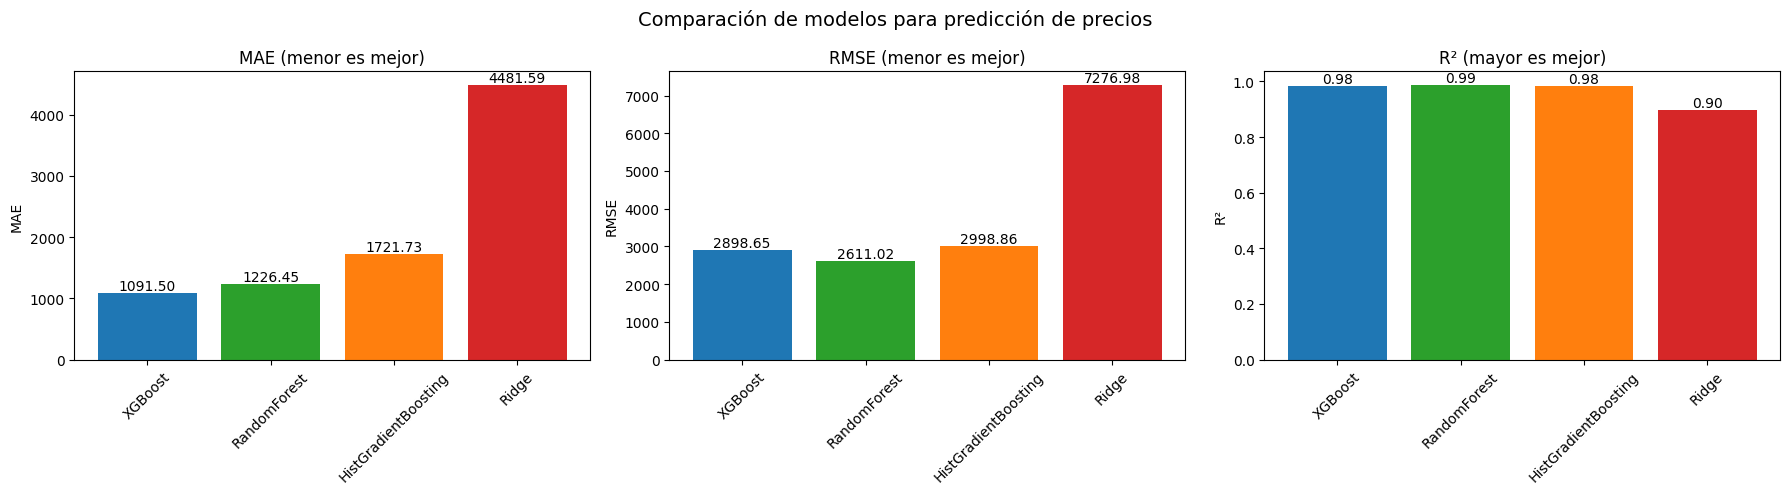

In [102]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharex=True)

colors = {
    "Ridge": "#1f77b4",                  # azul
    "RandomForest": "#2ca02c",           # verde
    "HistGradientBoosting": "#ff7f0e",   # naranjo
    "XGBoost": "#d62728"                 # rojo
}

bar_colors = [colors[m] for m in models]

def add_labels(ax, values):
    for i, v in enumerate(values):
        ax.text(
            i, v,
            f"{v:.2f}",
            ha="center",
            va="bottom",
            fontsize=10
        )

# --- MAE ---
axes[0].bar(results_df["Model"], results_df["MAE"], color=bar_colors)
axes[0].set_title("MAE (menor es mejor)")
axes[0].set_ylabel("MAE")
add_labels(axes[0], results_df["MAE"])
axes[0].tick_params(axis='x', rotation=45)

# --- RMSE ---
axes[1].bar(results_df["Model"], results_df["RMSE"], color=bar_colors)
axes[1].set_title("RMSE (menor es mejor)")
axes[1].set_ylabel("RMSE")
add_labels(axes[1], results_df["RMSE"])
axes[1].tick_params(axis='x', rotation=45)

# --- R2 ---
axes[2].bar(results_df["Model"], results_df["R2"], color=bar_colors)
axes[2].set_title("R² (mayor es mejor)")
axes[2].set_ylabel("R²")
add_labels(axes[2], results_df["R2"])
axes[2].tick_params(axis='x', rotation=45)

plt.suptitle("Comparación de modelos para predicción de precios", fontsize=14)
plt.tight_layout()
plt.show()

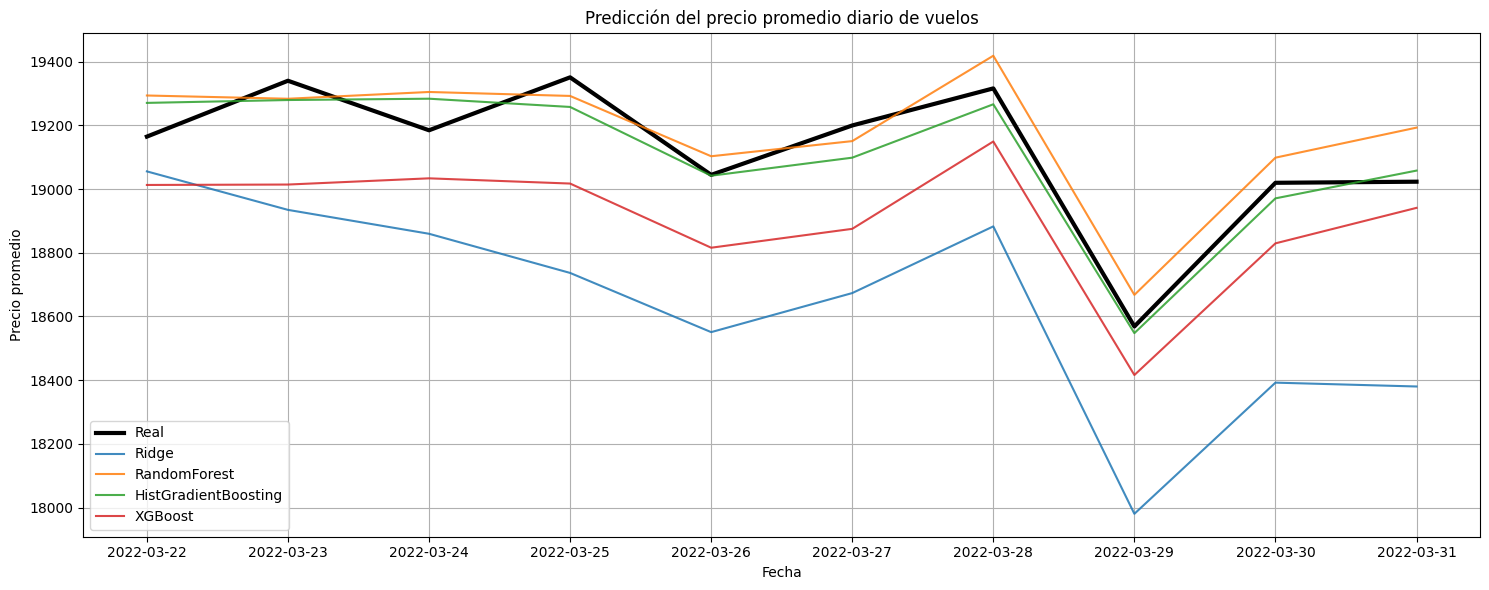

In [110]:
df_ts = clean_data(df, False)
df.ts = df_ts.sort_values("date")

df_daily = (
    df_ts.groupby("date", as_index=False)
         .agg(price_mean=("price", "mean"))
)

split_idx = int(len(df_daily) * 0.8)

train_dates = df_daily.iloc[:split_idx]["date"]
test_dates  = df_daily.iloc[split_idx:]["date"]

X = df_ts.drop(columns=["price"])
y = df_ts["price"]

X_train = X[df_ts["date"].isin(train_dates)]
y_train = y[df_ts["date"].isin(train_dates)]

X_test  = X[df_ts["date"].isin(test_dates)]
y_test  = y[df_ts["date"].isin(test_dates)]

models = {
    "Ridge": best_ridge,
    "RandomForest": best_rf,
    "HistGradientBoosting": best_hgb,
    "XGBoost": best_xgb
}

predictions_daily = {}

for name, model in models.items():
    y_pred = model.predict(X_test.drop(columns=["date"]))

    df_pred = pd.DataFrame({
        "date": df_ts.loc[X_test.index, "date"],
        "price_pred": y_pred
    })

    # Promedio diario predicho
    predictions_daily[name] = (
        df_pred.groupby("date", as_index=False)
               .agg(price_pred=("price_pred", "mean"))
    )

plt.figure(figsize=(15,6))

# Real
plt.plot(
    df_daily.loc[df_daily["date"].isin(test_dates), "date"],
    df_daily.loc[df_daily["date"].isin(test_dates), "price_mean"],
    label="Real",
    color="black",
    linewidth=3
)

# Modelos
for name, df_pred in predictions_daily.items():
    plt.plot(
        df_pred["date"],
        df_pred["price_pred"],
        label=name,
        alpha=0.85
    )

plt.title("Predicción del precio promedio diario de vuelos")
plt.xlabel("Fecha")
plt.ylabel("Precio promedio")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## 10. Conclusiones

Genera una conclusión final respecto a qué tan útiles son los resultados encontrados para resolver el problema propuesto y define cuáles podrían ser los próximos pasos para el proyecto.

---

### Conclusión:
>
> - **XGBoost** es el mejor modelo en términos de MAE (1,091.50), o sea, es el que comete el menor error promedio al predecir el precio. Además mantiene un R² alto (0.98), por lo que explica gran parte de la variabilidad del precio.
>
> - **RandomForest** queda muy cerca (MAE 1,226.45) y tiene el mejor R² (0.99), pero su MAE y RMSE indican que, en promedio, se equivoca más que XGBoost (aunque su RMSE es menor, lo que sugiere menos errores "muy grandes" en algunos casos).
>
> - **HistGradientBoosting** rinde bien (R² 0.98), pero con MAE y RMSE más altos que XGBoost y RandomForest, por lo que queda como tercera opción.
>
> - **Ridge** es claramente el peor: MAE 4,481.59 y RMSE 7,276.98, confirmando que un modelo lineal no captura bien la relación entre las variables y el precio.
>
> **XGBoost** es el mejor modelo en terminos generales y por tanto el modelo propuesto.
>
>
> **Propuestas**
>
> - Analizar los resultados de los modelos en diferentes segmentos (economy y business por ejemplo)
> - Afinar regularización para mejorar generalización y evitar sobreajuste
> - Mejorar el split para el dataset (train y test) usando por ejemplo la información de fechas